In [1]:
#import everything we might need and actually need in order to build a CNN that has a better accuracy than Jens'

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout

In [2]:
#load the dataset
ds, info = tfds.load("malaria", 
                     split="train", 
                     as_supervised=True, 
                     with_info=True, 
                     shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete8TOBE3/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


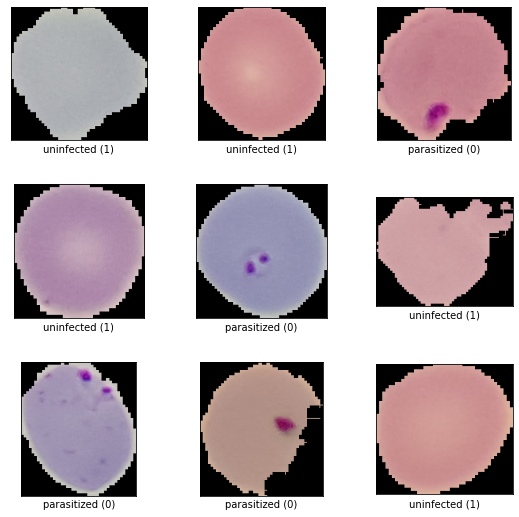

In [3]:
#sneak-peak of the dataset to understand what we are dealing with 

vis = tfds.visualization.show_examples(ds, info)

In [4]:
# function to convert dtype of each image to a tf.float + hotify the label 
def converting(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2)
  return image, label

# normalizing the image for our network
def normalize(image, label):
  image = (image - tf.reduce_min(image))/(tf.reduce_max(image)-tf.reduce_min(image))
  return image, label

# padding (or cropping) so the images all have the same size
def padding(image, label): 
  image, label = converting(image, label)
  image, label = normalize(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image, label



In [5]:
# actually calling functions defined above
# note that 'padding' is already calling the others so we only have to map(padding) onto our data

# also already batching
td = ds.cache().map(padding).batch(50)


In [6]:
# deviding our data into training + validation (test) data
test = td.take(10) 
training_data = td.skip(10)

In [11]:
# implemented a learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay((0.0001), 
                               decay_steps=3500, 
                               decay_rate=0.95, 
                               staircase=True)

# defining the optimizer 'Adam' including abovely defined learning rate decay
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# now building our actual model 
model = Sequential()

# 5 Conv2D layers with (Max-)Pooling layers right after
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', input_shape=(200, 200, 3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

# adding a dropout of 0.2 to prevent overfitting
model.add(Dropout(0.2))

# 2 dense layers with softmax as activation function since softmax returns a probability and BinaryCrossEntropy is working with that
model.add(Dense(32, 
                activation='softmax'))
model.add(Dense(2, 
                activation='softmax'))

# compiling the model
model.compile(optimizer=opt, 
              loss='BinaryCrossentropy', 
              metrics=['acc']
              )



In [12]:
# training the model on our training data and testing it on the validation set - 25 epochs
history = model.fit(training_data, validation_data=test, epochs=25)

Epoch 1/25
542/542 [==============================] - 77s 143ms/step - loss: 0.5754 - acc: 0.7435 - val_loss: 0.4635 - val_acc: 0.9040
Epoch 2/25
542/542 [==============================] - 77s 142ms/step - loss: 0.4368 - acc: 0.9160 - val_loss: 0.4063 - val_acc: 0.9380
Epoch 3/25
542/542 [==============================] - 77s 142ms/step - loss: 0.3934 - acc: 0.9358 - val_loss: 0.3698 - val_acc: 0.9580
Epoch 4/25
542/542 [==============================] - 77s 142ms/step - loss: 0.3634 - acc: 0.9428 - val_loss: 0.3485 - val_acc: 0.9480
Epoch 5/25
542/542 [==============================] - 77s 143ms/step - loss: 0.3390 - acc: 0.9468 - val_loss: 0.3240 - val_acc: 0.9540
Epoch 6/25
542/542 [==============================] - 77s 142ms/step - loss: 0.3182 - acc: 0.9491 - val_loss: 0.3000 - val_acc: 0.9580
Epoch 7/25
542/542 [==============================] - 77s 142ms/step - loss: 0.2995 - acc: 0.9508 - val_loss: 0.2816 - val_acc: 0.9580
Epoch 8/25
542/542 [==============================] - 7

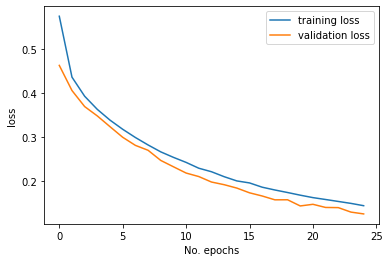

In [13]:
# plotting the loss on both training and validation data

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc="upper right")
plt.ylabel('loss')
plt.xlabel('No. epochs')
plt.show()

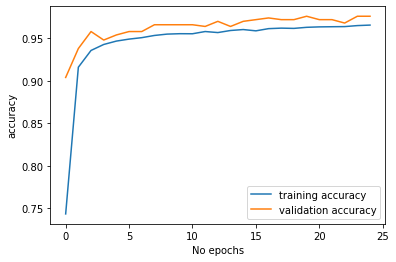

0.9760000109672546


In [14]:
# plotting accuracy on training and validation data

plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.xlabel('No epochs')
plt.ylabel('accuracy')
plt.legend(loc="lower right")
plt.show()
print(history.history['val_acc'][-1])